In [1]:
import pygmt

In [2]:
import pygmt
import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import time

In [41]:
iq_lats = pd.read_csv('icequakes_catalog.csv')['latitude']
iq_lons = pd.read_csv('icequakes_catalog.csv')['longitude']

eq_lats = pd.read_csv('earthquakes_catalog.csv')['latitude']
eq_lons = pd.read_csv('earthquakes_catalog.csv')['longitude']

stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])


stations = stns.values[:,1].astype('str')
stn_lats = stns.values[:,2].astype('float')
stn_lons = stns.values[:,3].astype('float')
gl_lat, gl_lon = 61.219722, -146.895278


gl_lats = [61.22215, 61.23980, 61.28859, 61.38921]
gl_lons = [-146.89464,-147.41556, -147.47800,-147.43615]
glaciers = ['Columbia', 'Meares', 'Yale', 'Harvard']

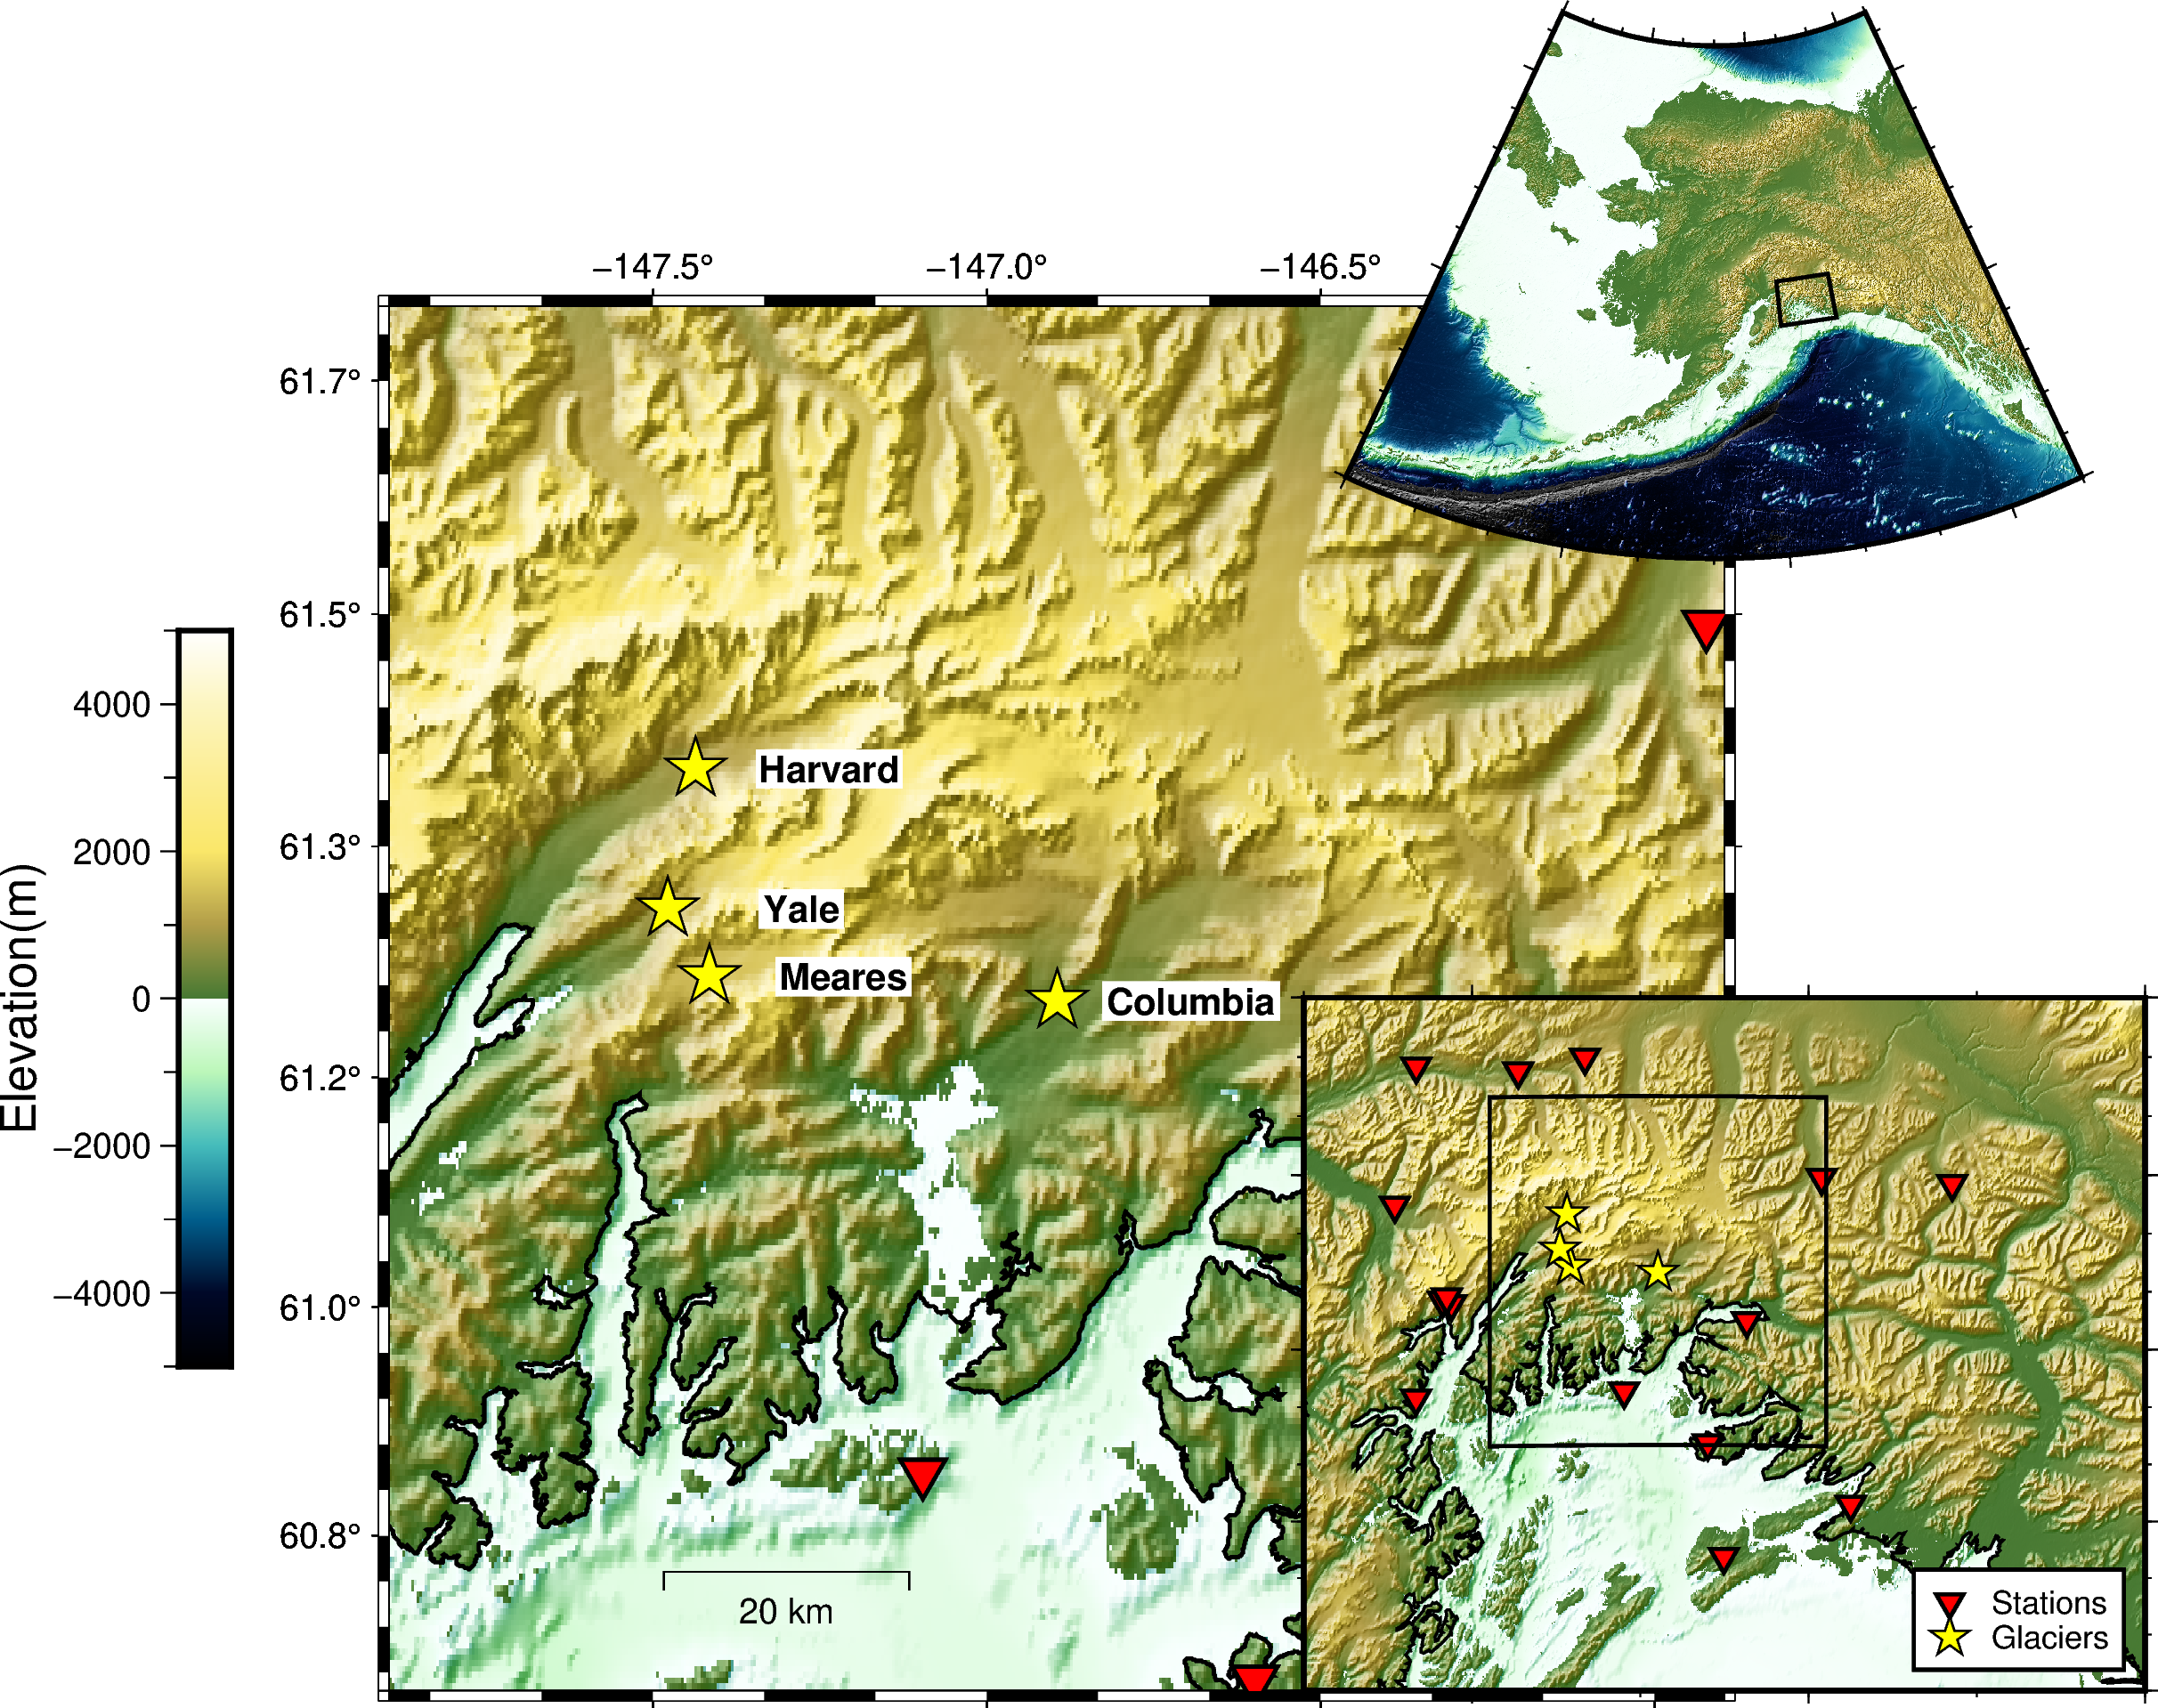

In [89]:
region = [gl_lon-1 ,gl_lon+1 ,gl_lat-0.5, gl_lat+0.5]
fig = pygmt.Figure()
pygmt.makecpt(cmap='relief',series='-5000/5000/1000',continuous=True)
topo_data = '@earth_relief_15s'
pygmt.config(FORMAT_GEO_MAP="ddd.x")
fig.grdimage(grid=topo_data,region=region,projection='M5i',shading=True,cmap=True,
            frame=["WsNe", "xaf", "yaf"])
#pygmt.makecpt(cmap="plasma", series=[np.min(depths),25])
fig.coast(area_thresh = 10000,
    shorelines='1p,black',
#          water="lightblue",
          region=region,
#          borders="1/thick",
         frame=["WsNe", "xaf", "yaf"], 
          map_scale='"g-147.3/60.8+w20"')

fig.colorbar(frame='af+l"Elevation(m)"', position="JML+o1.5c/0c+w7c/0.5c")
pygmt.makecpt(cmap="plasma", series = [70,100])


#fig.plot(x=stn_lons,y=stn_lats,style='ic',size = (np.array(size)*(0.00017)),color=np.array(accuracy_1_10_modified_pca)*100,pen='1p,black',
#         region=region, cmap=True,)

fig.plot(x=stn_lons, y=stn_lats,style='i0.5c',color='red',pen='1p,black',
         region=region, cmap=False,label='Stations')
fig.plot(x=gl_lons,y=gl_lats,style='a0.6c',color='yellow',pen='0.5p,black',
         region=region)
fig.text(text=glaciers, y=gl_lats, x=np.array(gl_lons)+0.2,font="10p,Helvetica-Bold,black",fill='white')
#fig.text(text=stations[3:],y=stn_lats[3:]+0.00,x=stn_lons[3:]+0.30,font="7p,Helvetica-Bold,black",fill='white')
#fig.colorbar(frame='af+l"Accuracy(%)"')

region1 = [-149.0, -144, 60, 62]
rectangle = [[region1[0], region1[2], region1[1], region1[3]]]
fig.plot(data=rectangle, style="r+s", pen="1p,black",projection='M5i')

with fig.inset(position="jBR+w8c+o-4.0c/0.0c", box=False,no_clip=True):
    # Plot the Japan main land in the inset using coast. "U54S/?" means UTM
    # projection with map width automatically determined from the inset width.
    # Highlight the Japan area in "lightbrown"
    # and draw its outline with a pen of "0.2p".
    topo_data = '@earth_relief_15s'
    proj = "M8c"
    pygmt.makecpt(cmap='relief',series='-5000/5000/1000',continuous=True)
    fig.grdimage(grid=topo_data, region=region1,projection=proj,shading=True,            
                 frame=["wsne", "xaf", "yaf"], cmap=True)
    
    pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain")
    rectangle = [[region[0], region[2], region[1], region[3]]]
    #fig.plot(data=rectangle, style="r+s", pen="2p,blue",projection=proj)
    fig.coast(area_thresh = 10000,
        region=region1,
        projection=proj,
        borders=["2/thin","1/thin"],
        shorelines="thin",
#        water="azure1",
#        land= 'lightyellow',
        frame=["wsne"],
        resolution = 'h')
    pygmt.makecpt(cmap="plasma", series = [70,100])
    fig.plot(x=stn_lons,projection=proj, y=stn_lats,style='i0.3c',color='red',pen='1p,black',
         region=region1, cmap=False,label='Stations')
    fig.plot(x=gl_lons,y=gl_lats,style='a0.4c',color='yellow',pen='0.5p,black',
         region=region1, label='Glaciers')

#    fig.text(text=stations,y=stn_lats+0.00,x=stn_lons+0.05,region=region1, projection=proj, font="6p,Helvetica-Bold,black",fill='white')
    fig.plot(data=rectangle, style="r+s", pen="1p,black",projection=proj, region=region1)
    fig.legend(position='JBR+jBR+o0.2c', box='+gwhite+p1p')
    
region2 = [-180, -130, 50, 73]    
with fig.inset(position="jTR+w2c+o1.6c/0.4c", box=False,no_clip=True):
    # Plot the Japan main land in the inset using coast. "U54S/?" means UTM
    # projection with map width automatically determined from the inset width.
    # Highlight the Japan area in "lightbrown"
    # and draw its outline with a pen of "0.2p".
    topo_data = '@earth_relief_01m'
    proj = 'S-155/90/7c'
    pygmt.makecpt(cmap='relief',series='-5000/5000/1000',continuous=True)
    fig.grdimage(grid=topo_data, region=region2,projection=proj,shading=True,            
                 frame=["wsne", "xaf", "yaf"], cmap=True)
    
    pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain")
    rectangle = [[region1[0], region1[2], region1[1], region1[3]]]
    #fig.plot(data=rectangle, style="r+s", pen="2p,blue",projection=proj)
    '''fig.coast(area_thresh = 10000,
        region=region2,
        projection=proj,
        borders=["2/thin","1/thin"],
        shorelines="thin",
#        water="azure1",
#        land= 'lightyellow',
        frame=["wsne"],
        resolution = 'l')
    #pygmt.makecpt(cmap="plasma", series = [70,100])
    #fig.plot(x=stn_lons,projection=proj, y=stn_lats,style='ic',size = (np.array(size)*(0.0005)),color=np.array(accuracy_1_10_modified_pca)*100,pen='1p,black',
    #     region=region1, cmap=True,)
    #fig.text(text=stations,y=stn_lats+0.00,x=stn_lons+0.05,region=region1, projection=proj, font="6p,Helvetica-Bold,black",fill='white')
    fig.plot(data=rectangle, style="r+s", pen="1p,blue",projection=proj)
    '''
    fig.plot(data=rectangle, style="r+s", pen="1p,black",projection=proj)
    
fig.show()

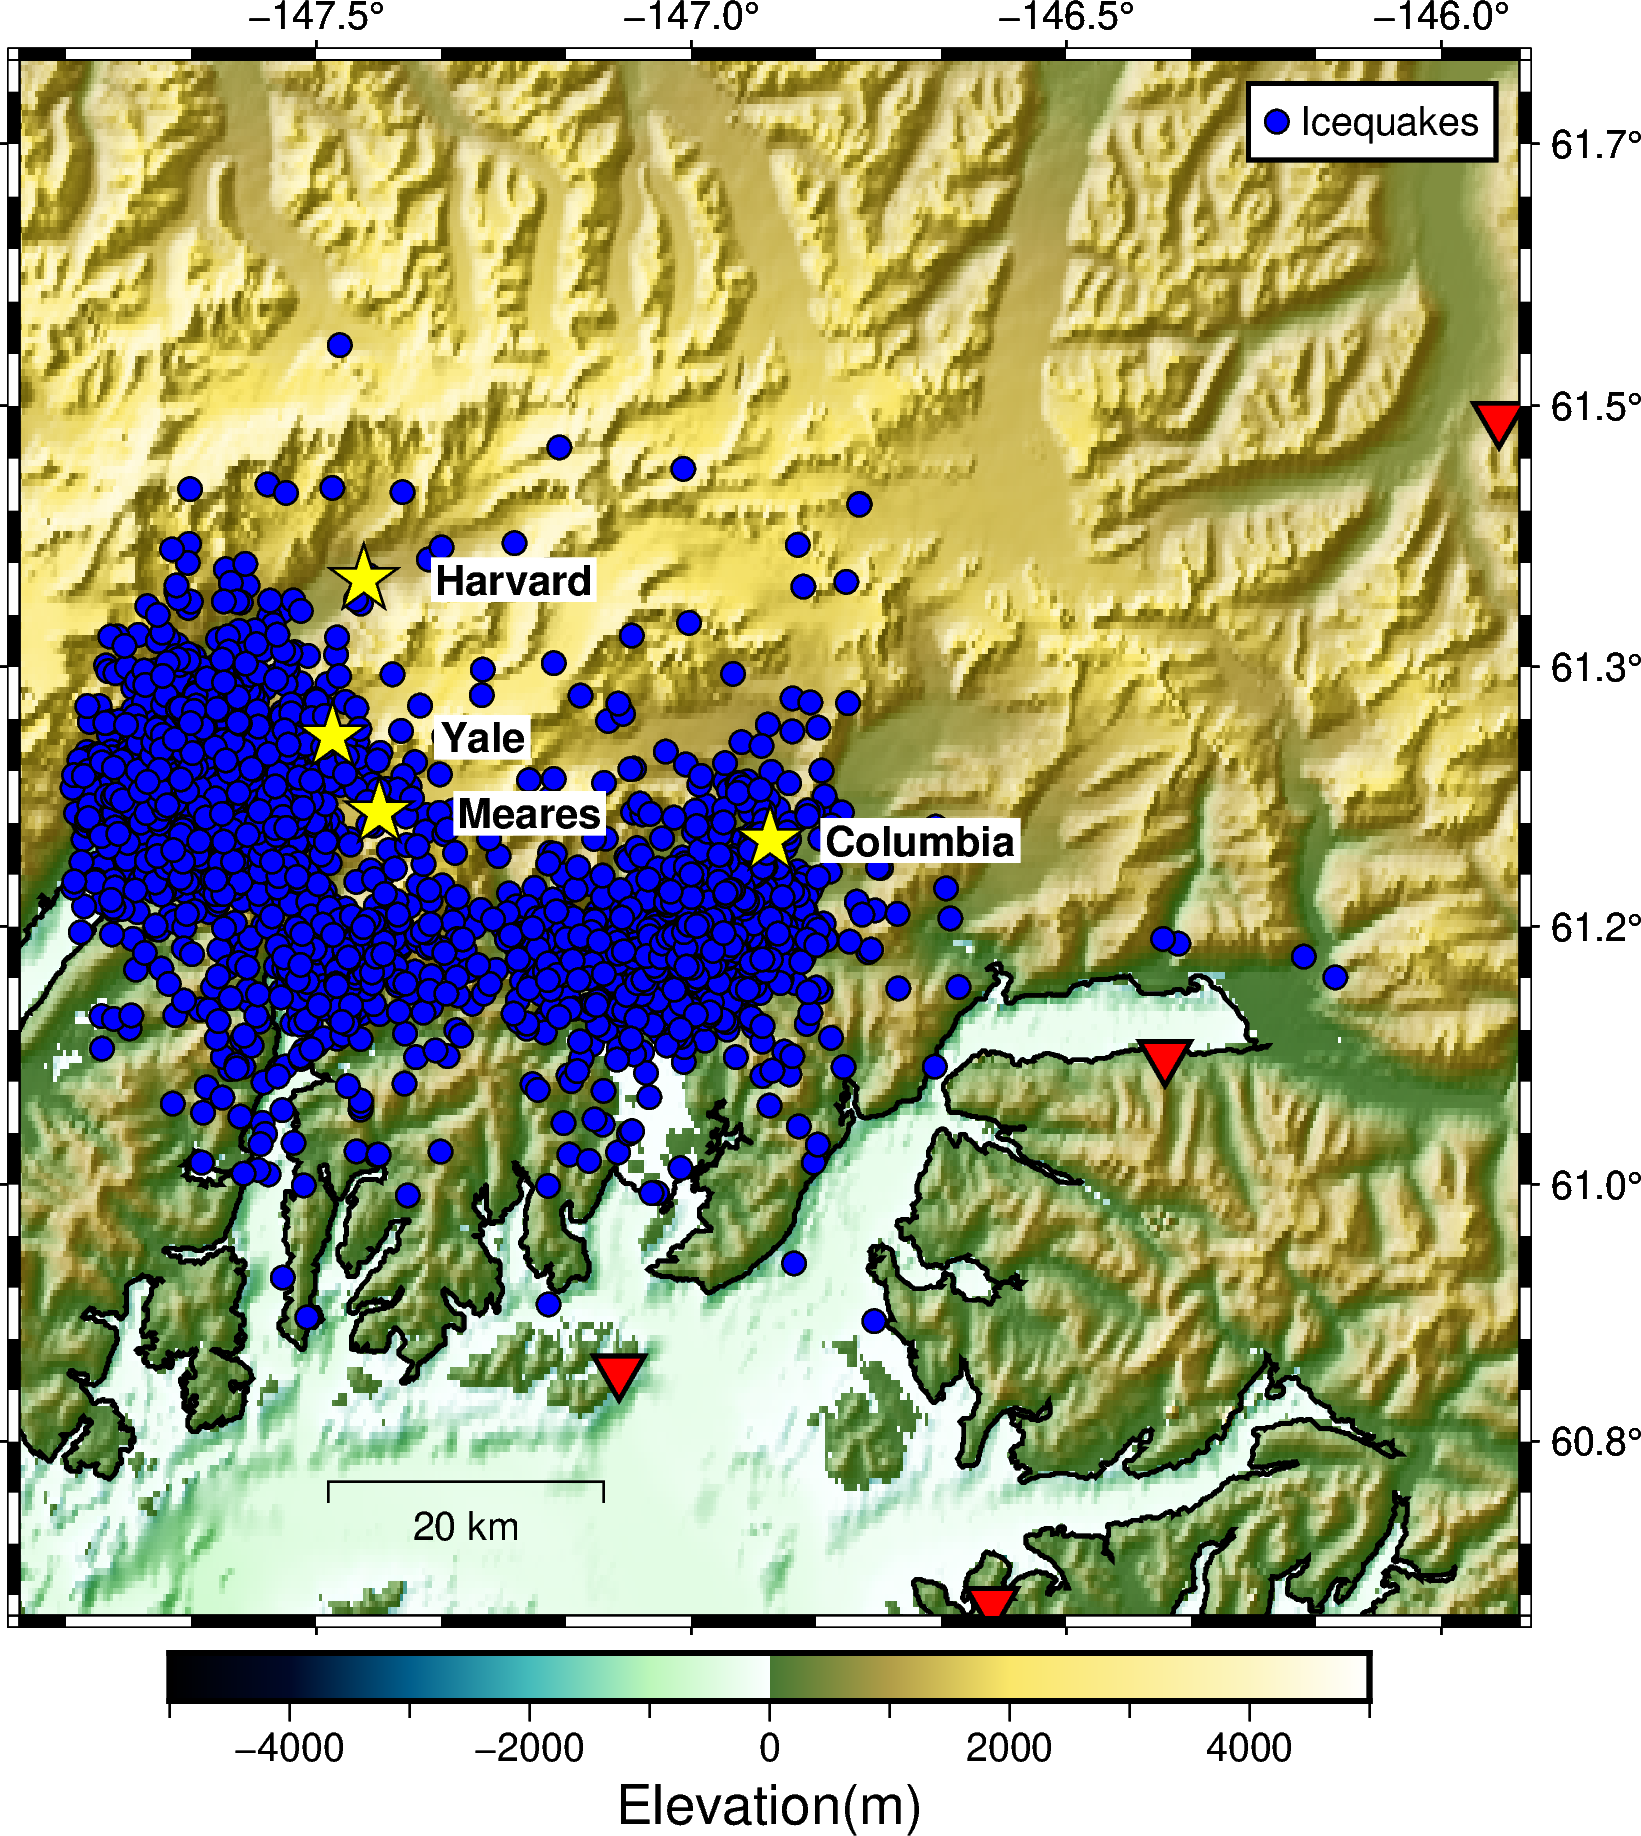

In [84]:
region = [gl_lon-1, gl_lon+1, gl_lat-0.5, gl_lat+0.5]
fig = pygmt.Figure()
pygmt.makecpt(cmap='relief',series='-5000/5000/1000',continuous=True)
topo_data = '@earth_relief_15s'
pygmt.config(FORMAT_GEO_MAP="ddd.x")
fig.grdimage(grid=topo_data,region=region,projection='M5i',shading=True,cmap=True,
            frame=["wsNE", "xaf", "yaf"])
#pygmt.makecpt(cmap="plasma", series=[np.min(depths),25])
fig.coast(area_thresh = 10000,
    shorelines='1p,black',
#          water="lightblue",
          region=region,
#          borders="1/thick",
         frame=["wsNE", "xaf", "yaf"], 
          map_scale='"g-147.3/60.8+w20"')

fig.colorbar(frame='af+l"Elevation(m)"')
pygmt.makecpt(cmap="plasma", series = [70,100])

fig.plot(x=iq_lons,y=iq_lats,style='c0.2c',color='blue',pen='0.5p,black',
         region=region,transparency=0, label='Icequakes')
fig.plot(x=stn_lons, y=stn_lats,style='i0.5c',color='red',pen='1p,black',
         region=region, cmap=False)
fig.plot(x=gl_lons,y=gl_lats,style='a0.6c',color='yellow',pen='0.5p,black',
         region=region, )
fig.text(text=glaciers, y=gl_lats, x=np.array(gl_lons)+0.2,font="10p,Helvetica-Bold,black",fill='white')
fig.legend()
fig.show()

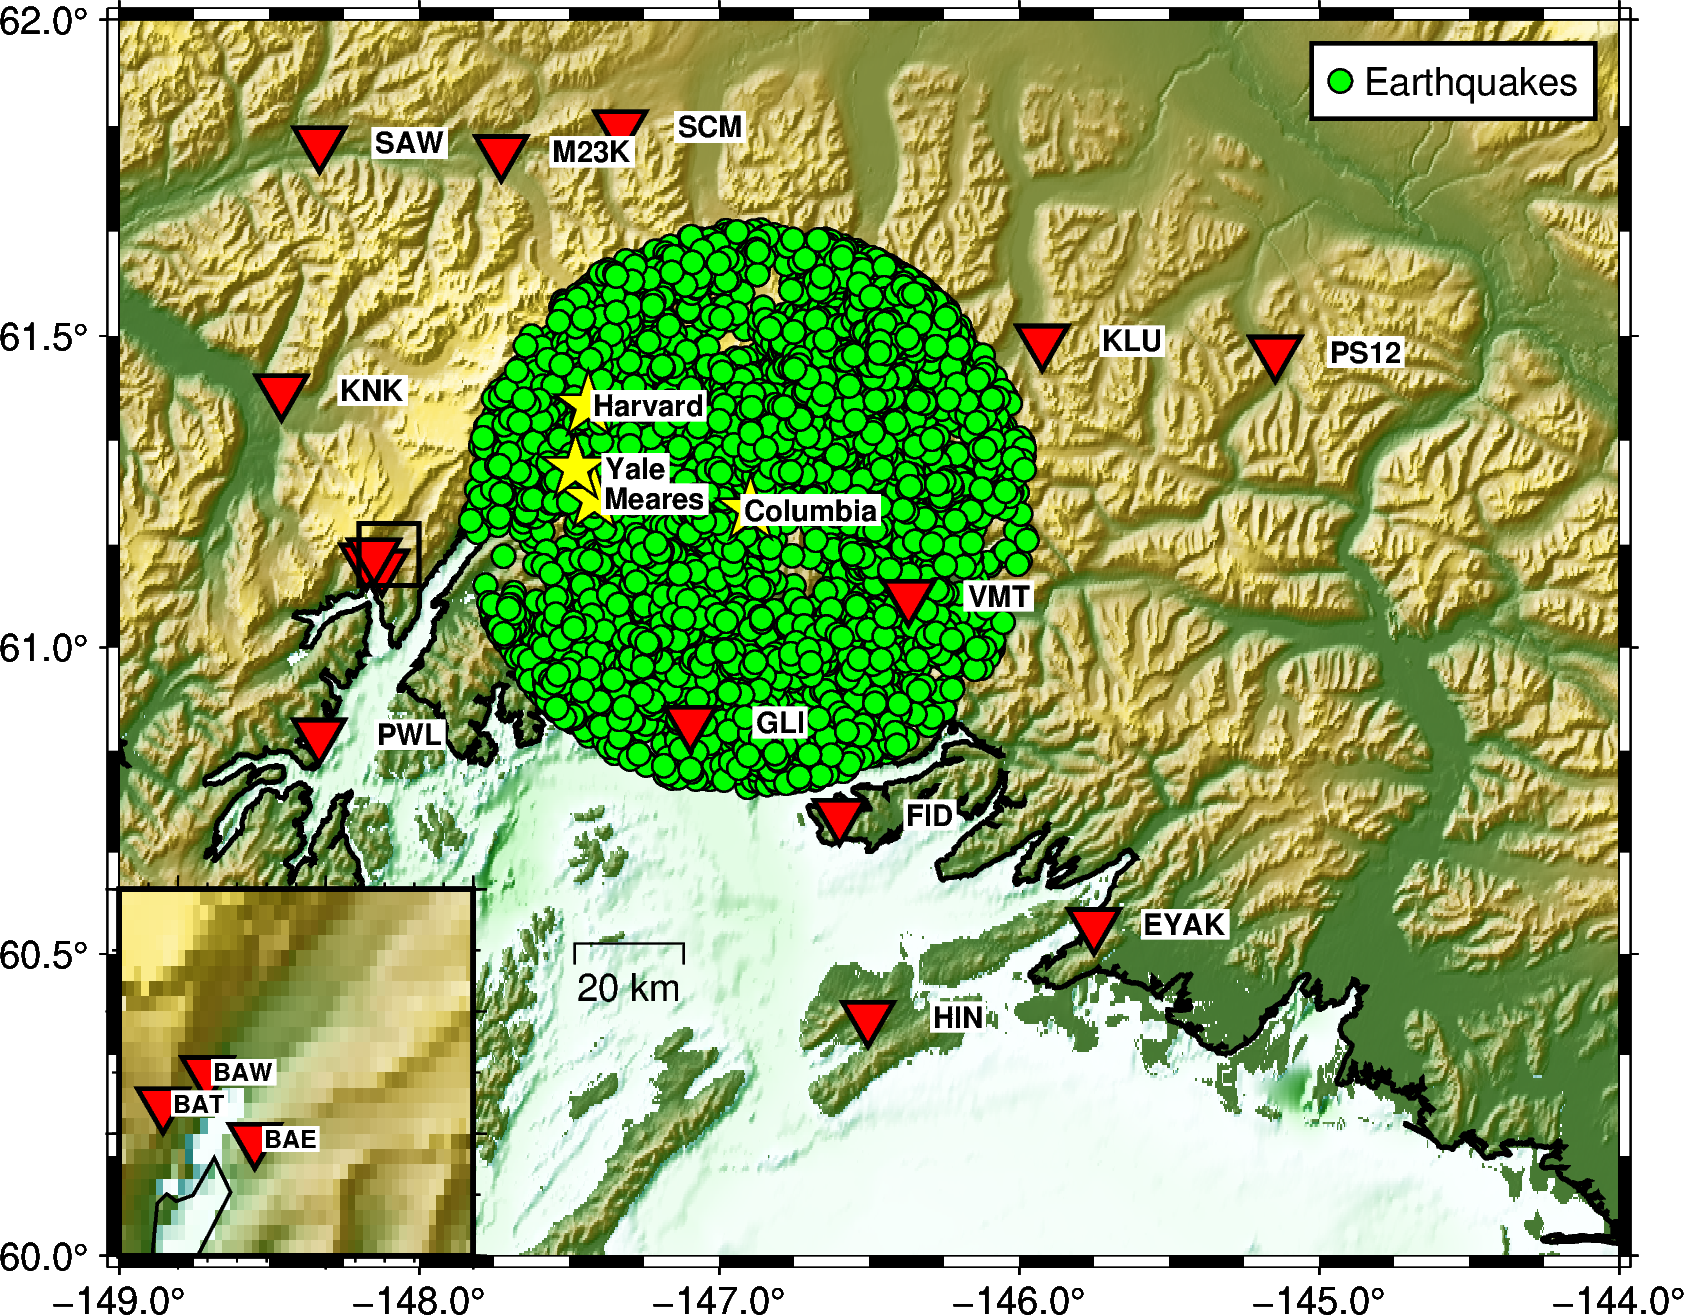

In [83]:
region = [-149.0, -144, 60, 62]
fig = pygmt.Figure()
pygmt.makecpt(cmap='relief',series='-5000/5000/1000',continuous=True)
topo_data = '@earth_relief_15s'
pygmt.config(FORMAT_GEO_MAP="ddd.x")
fig.grdimage(grid=topo_data,region=region,projection='M5i',shading=True,cmap=True,
            frame=["WSne", "xaf", "yaf"])
#pygmt.makecpt(cmap="plasma", series=[np.min(depths),25])
fig.coast(area_thresh = 10000,
    shorelines='1p,black',
#          water="lightblue",
          region=region,
#          borders="1/thick",
         frame=["WSne", "xaf", "yaf"], 
          map_scale='"g-147.3/60.5+w20"')

#fig.colorbar(frame='af+l"Elevation(m)"')
pygmt.makecpt(cmap="plasma", series = [70,100])

fig.plot(x=eq_lons,y=eq_lats,style='c0.2c',color='green',pen='0.5p,black',
         region=region,transparency=0, label='Earthquakes')
fig.plot(x=stn_lons, y=stn_lats,style='i0.5c',color='red',pen='1p,black',
         region=region, cmap=False)
fig.plot(x=gl_lons,y=gl_lats,style='a0.6c',color='yellow',pen='0.5p,black',
         region=region)
fig.text(text=glaciers, y=gl_lats, x=np.array(gl_lons)+0.2,font="7p,Helvetica-Bold,black",fill='white')
fig.text(text=stations[3:],y=stn_lats[3:]+0.00,x=stn_lons[3:]+0.30,font="7p,Helvetica-Bold,black",fill='white')
fig.legend()
region1 = [-148.2,-148,61.1,61.2]
rectangle = [[region1[0], region1[2], region1[1], region1[3]]]
fig.plot(data=rectangle, style="r+s", pen="1p,black",projection='M5i')

with fig.inset(position="jBL+w2c+o-0.0c/-0.0c", box=False,no_clip=True):
    # Plot the Japan main land in the inset using coast. "U54S/?" means UTM
    # projection with map width automatically determined from the inset width.
    # Highlight the Japan area in "lightbrown"
    # and draw its outline with a pen of "0.2p".
    topo_data = '@earth_relief_15s'
    proj = "M3c"
    pygmt.makecpt(cmap='relief',series='-5000/5000/1000',continuous=True)
    fig.grdimage(grid=topo_data, region=region1,projection=proj,shading=True,            
                 frame=["wsne", "xaf", "yaf"], cmap=True)
    
    pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain")
    #rectangle = [[region[0], region[2], region[1], region[3]]]
    #fig.plot(data=rectangle, style="r+s", pen="2p,blue",projection=proj)
    fig.coast(area_thresh = 10000,
        region=region1,
        projection=proj,
        borders=["2/thin","1/thin"],
        shorelines="thin",
#        water="azure1",
#        land= 'lightyellow',
        frame=["wsne"],
        resolution = 'h')
    pygmt.makecpt(cmap="plasma", series = [70,100])
    fig.plot(x=stn_lons, y=stn_lats,style='i0.5c',color='red',pen='1p,black',
         region=region1, projection=proj,cmap=False)
    fig.text(text=stations,y=stn_lats+0.00,x=stn_lons+0.02,region=region1, projection=proj, font="6p,Helvetica-Bold,black",fill='white')
    #fig.plot(data=rectangle, style="r+s", pen="1p,blue",projection=proj)

fig.show()